# Case Study - Collared Floater

# Introduction

A **collared floater** pays a floating-rate coupon bounded by a floor and a cap:

$$\max(K_{\text{floor}},\; \min(r,\; K_{\text{cap}}))$$

It can be replicated with three instruments:

| Instrument | Position |
|------------|----------|
| Floating-rate note | +1 |
| Floor (strike = $K_{\text{floor}}$) | +1 |
| Cap (strike = $K_{\text{cap}}$) | -1 |

# Setup


In [21]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import fsolve

In [22]:
# from cmds.ratecurves import recalc_rates_from_spot
# from cmds.ficcvol import flat_to_forward_vol, cap_vol_to_price, price_collared_floater

# Data

Use the data from the following file.
* `../data/fiderivs_2025-03-10.xlsx`

In [23]:
DATE = '2025-03-10'
FILEIN = f'./data/fiderivs_{DATE}.xlsx'

curves = pd.read_excel(FILEIN, sheet_name='rate curves').set_index('tenor')
curves.style.format('{:.1%}').format_index('{:.2f}')

,swap rates,spot rates,discounts,forwards,flat vols
tenor,,,,,
0.25,4.2%,4.2%,99.0%,nan%,nan%
0.50,4.1%,4.1%,98.0%,4.0%,14.6%
0.75,4.0%,4.0%,97.1%,3.7%,16.9%
1.00,3.9%,3.9%,96.2%,3.6%,19.1%
1.25,3.8%,3.8%,95.4%,3.4%,22.2%
1.50,3.7%,3.7%,94.6%,3.4%,24.5%
1.75,3.7%,3.7%,93.8%,3.4%,26.1%
2.00,3.7%,3.7%,93.0%,3.5%,27.2%
2.25,3.6%,3.6%,92.2%,3.4%,27.9%


### Parameters


In [24]:
NOTIONAL = 100
T = 5                   # Maturity in years
CPNFREQ = 4             # Quarterly coupons
FREQ_CURVE = 4          # Quarterly compounding

BOUND_LOWER = 0.02      # 2% floor
BOUND_UPPER = 0.05      # 5% cap

# 1. Pricing the Components


### 1.1.

A floater with no credit spread trades at par. Record the floater value.

In [25]:
floater_value = NOTIONAL  # = 100
print(f"Floater value: ${floater_value:.2f}")

Floater value: $100.00


### 1.2.

Price the **floor** (strike = 2%) and the **cap** (strike = 5%).

Use the flat vol at the 5-year tenor from the `curves` table.

Report both prices.

In [26]:
from math import log, sqrt, erf

# Copying functions from E7.1

def norm_cdf(x):
    return 0.5 * (1.0 + erf(x / sqrt(2.0)))

def black76_option(F, K, sigma, t_exp, option='call'):
    """Black-76 price of an option on a forward rate."""
    if t_exp <= 0 or sigma <= 0:
        return max(F - K, 0) if option == 'call' else max(K - F, 0)
    vol_sqrt_t = sigma * sqrt(t_exp)
    d1 = (log(F / K) + 0.5 * sigma**2 * t_exp) / vol_sqrt_t
    d2 = d1 - vol_sqrt_t
    if option == 'call':
        return F * norm_cdf(d1) - K * norm_cdf(d2)
    else:
        return K * norm_cdf(-d2) - F * norm_cdf(-d1)

def price_cap_or_floor(curves, T, strike, notional, freq, kind):
    """
    Price a cap or floor with fixed strike using the flat vol at maturity T.
    kind: 'cap' or 'floor'
    """
    accrual = 1 / freq
    sigma = curves.loc[T, 'flat vols']          # flat vol at 5-year tenor
    option = 'call' if kind == 'cap' else 'put'

    pay_dates = [round(t, 2) for t in list(
        pd.Series(range(int(0.75 * freq), int(T * freq) + 1)) / freq
    )]

    total_pv = 0.0
    for T_pay in pay_dates:
        F      = curves.loc[T_pay, 'forwards']
        df_pay = curves.loc[T_pay, 'discounts']
        t_fix  = T_pay - accrual               # rate fixes one period before payment

        black_price = black76_option(F, strike, sigma, t_fix, option=option)
        pv = notional * accrual * df_pay * black_price
        total_pv += pv

    return total_pv

# --- Price the floor and cap ---
floor_value = price_cap_or_floor(curves, T=T, strike=BOUND_LOWER,
                                  notional=NOTIONAL, freq=CPNFREQ, kind='floor')
cap_value   = price_cap_or_floor(curves, T=T, strike=BOUND_UPPER,
                                  notional=NOTIONAL, freq=CPNFREQ, kind='cap')

print(f"Floor value (K=2%): ${floor_value:.4f}")
print(f"Cap value   (K=5%): ${cap_value:.4f}")


Floor value (K=2%): $0.2449
Cap value   (K=5%): $0.9742


### 1.3.

Combine the three instruments into the replicating portfolio:
* +1 Floater
* +1 Floor (2%)
* -1 Cap (5%)

Report the NAV of each component and the total portfolio value.

Is the portfolio worth more or less than par? Why?


In [27]:
portfolio_value = floater_value + floor_value - cap_value

print(f"Floater NAV = ${floater_value:.4f}")
print(f"Floor NAV = ${floor_value:.4f}")
print(f"Cap NAV = ${cap_value:.4f}")
print(f"Portfolio NAV = ${portfolio_value:.4f}")

print(f"\n5-year spot rate = {curves.loc[5.0, 'spot rates']:.4f}")

Floater NAV = $100.0000
Floor NAV = $0.2449
Cap NAV = $0.9742
Portfolio NAV = $99.2708

5-year spot rate = 0.0361


The collared floater portfolio is worth $99.27, which is $0.73 below par. This is because the cap (strike 5%) is more valuable than the floor (strike 2%). At current 5-year rates of ~3.6%, the cap is only 1.4% out-of-the-money while the floor is 1.6% out-of-the-money, and with a flat vol of ~28% there is meaningful probability of rates reaching 5% over the 5-year horizon. As a result, the investor sells the cap for $0.97 but only pays $0.24 for the floor, so the net cost of the collar reduces the portfolio value below par.

# 2. Risk Analysis


### 2.1.

Calculate the **duration** of the portfolio numerically by applying a 1bp parallel shock to the spot curve.

Report the duration of each component and the portfolio.

In [28]:
DR = 0.0001

def reprice_curves(curves, dr, freq=4):
    """Parallel shift spot rates by dr and recompute discounts and forwards."""
    c = curves.copy()
    c['spot rates'] = c['spot rates'] + dr

    # Recompute discount factors: Z(t) = 1 / (1 + r(t)/m)^(t*m)
    tenors = list(c.index)
    c['discounts'] = [1 / (1 + c.loc[t, 'spot rates'] / freq) ** (t * freq)
                      for t in tenors]

    # Recompute forward rates: F(t) = (Z(t-1/m) / Z(t) - 1) * m
    new_fwds = [float('nan')]
    for i in range(1, len(tenors)):
        t_prev, t_curr = tenors[i-1], tenors[i]
        accrual = t_curr - t_prev
        fwd = (c.loc[t_prev, 'discounts'] / c.loc[t_curr, 'discounts'] - 1) / accrual
        new_fwds.append(fwd)
    c['forwards'] = new_fwds

    return c

# Shocked curves
curves_up = reprice_curves(curves, DR)
curves_down = reprice_curves(curves, -DR)

# Reprice all components under both shocks
floater_up = NOTIONAL
floater_down = NOTIONAL

floor_up = price_cap_or_floor(curves_up, T=T, strike=BOUND_LOWER, notional=NOTIONAL, freq=CPNFREQ, kind='floor')
floor_down = price_cap_or_floor(curves_down, T=T, strike=BOUND_LOWER, notional=NOTIONAL, freq=CPNFREQ, kind='floor')

cap_up = price_cap_or_floor(curves_up, T=T, strike=BOUND_UPPER, notional=NOTIONAL, freq=CPNFREQ, kind='cap')
cap_down = price_cap_or_floor(curves_down, T=T, strike=BOUND_UPPER, notional=NOTIONAL, freq=CPNFREQ, kind='cap')

portfolio_up = floater_up + floor_up - cap_up
portfolio_down = floater_down + floor_down - cap_down

# Effective duration = -(P_up - P_down) / (2 * P_0 * DR)
def eff_dur(p_up, p_down, p_base):
    return -(p_up - p_down) / (2 * p_base * DR)

dur_floater = eff_dur(floater_up, floater_down, floater_value)
dur_floor = eff_dur(floor_up, floor_down, floor_value)
dur_cap = eff_dur(cap_up, cap_down, cap_value)
dur_portfolio = eff_dur(portfolio_up, portfolio_down, portfolio_value)

print(f"{'Component':<20} {'P(-1bp)':>10} {'P(base)':>10} {'P(+1bp)':>10} {'Eff. Dur':>10}")
print("-" * 62)
print(f"{'Floater':<20} ${floater_down:>9.4f} ${floater_value:>9.4f} ${floater_up:>9.4f} {dur_floater:>10.4f}")
print(f"{'Floor (K=2%)':<20} ${floor_down:>9.4f} ${floor_value:>9.4f} ${floor_up:>9.4f} {dur_floor:>10.4f}")
print(f"{'Cap   (K=5%)':<20} ${cap_down:>9.4f} ${cap_value:>9.4f} ${cap_up:>9.4f} {dur_cap:>10.4f}")
print("-" * 62)
print(f"{'Portfolio':<20} ${portfolio_down:>9.4f} ${portfolio_value:>9.4f} ${portfolio_up:>9.4f} {dur_portfolio:>10.4f}")


Component               P(-1bp)    P(base)    P(+1bp)   Eff. Dur
--------------------------------------------------------------
Floater              $ 100.0000 $ 100.0000 $ 100.0000     0.0000
Floor (K=2%)         $   0.2475 $   0.2449 $   0.2424   103.8591
Cap   (K=5%)         $   0.9636 $   0.9742 $   0.9848  -108.5760
--------------------------------------------------------------
Portfolio            $  99.2838 $  99.2708 $  99.2576     1.3217


### 2.2.

Calculate the **OAS** of the portfolio.

If the market quotes this note at par (100.00), what parallel shift to the spot curve would match that price?

Use `fsolve` to find the OAS.

In [29]:
def portfolio_price(oas):
    c = reprice_curves(curves, oas)
    fl_val  = price_cap_or_floor(c, T=T, strike=BOUND_LOWER, notional=NOTIONAL, freq=CPNFREQ, kind='floor')
    cap_val = price_cap_or_floor(c, T=T, strike=BOUND_UPPER, notional=NOTIONAL, freq=CPNFREQ, kind='cap')
    return NOTIONAL + fl_val - cap_val

oas = fsolve(lambda s: portfolio_price(s) - NOTIONAL, x0=0.0)[0]

print(f"OAS = {oas * 10000:.2f} bp")
print(f"Portfolio price at OAS: ${portfolio_price(oas):.6f}")

OAS = -59.82 bp
Portfolio price at OAS: $100.000000


The portfolio exhibits positive convexity at low rates (below the 2% floor): the long floor becomes increasingly valuable as rates fall, and the price curve bends upward. Between the floor and cap strikes, the portfolio is nearly linear with a shallow slope, reflecting the near-zero duration of the floater. Above the 5% cap, the rate of price decline slows — the short cap is deeply in-the-money but its delta has saturated, so further rate increases add diminishing losses. Overall, the collar truncates both tails, compressing the convexity profile relative to a pure fixed-rate bond.

### 2.3.

Plot the portfolio value across a range of interest rate scenarios (shock the spot curve from -300bp to +300bp).

On your plot, mark the current rate, the floor (2%), and the cap (5%).

Describe what you see in terms of convexity.

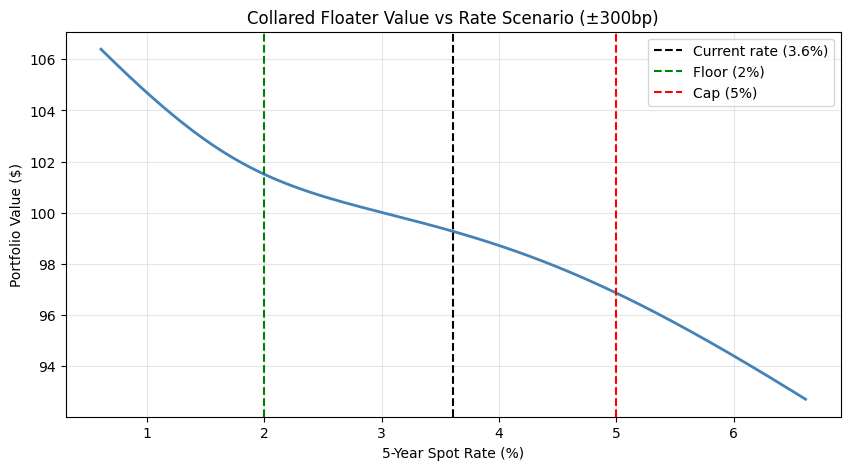

In [30]:
shocks = np.linspace(-0.03, 0.03, 200)
port_vals = []

for s in shocks:
    c = reprice_curves(curves, s)
    fl_val = price_cap_or_floor(c, T=T, strike=BOUND_LOWER, notional=NOTIONAL, freq=CPNFREQ, kind='floor')
    cap_val = price_cap_or_floor(c, T=T, strike=BOUND_UPPER, notional=NOTIONAL, freq=CPNFREQ, kind='cap')
    port_vals.append(NOTIONAL + fl_val - cap_val)

current_rate = curves.loc[5.0, 'spot rates']
x_rates = (shocks + current_rate) * 100  # absolute rate level in %

plt.figure(figsize=(10, 5))
plt.plot(x_rates, port_vals, color='steelblue', lw=2)
plt.axvline(current_rate * 100, color='black', linestyle='--', label=f'Current rate ({current_rate*100:.1f}%)')
plt.axvline(BOUND_LOWER * 100,  color='green',  linestyle='--', label=f'Floor ({BOUND_LOWER*100:.0f}%)')
plt.axvline(BOUND_UPPER * 100,  color='red',    linestyle='--', label=f'Cap ({BOUND_UPPER*100:.0f}%)')
plt.xlabel('5-Year Spot Rate (%)')
plt.ylabel('Portfolio Value ($)')
plt.title('Collared Floater Value vs Rate Scenario (±300bp)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 3. Stress Test: A +300bp Shock


In 1994, the Federal Reserve raised rates roughly 300bp in under a year, causing large losses on structured note portfolios — most notably Orange County's $1.7 billion loss.

Orange County held primarily **inverse floaters** (coupon = Fixed Rate $-$ Multiplier $\times$ Floating Rate), which are more aggressive than a collared floater. But it is instructive to see what a +300bp shock does to our product.


### 3.1.

Compute the portfolio value after a +300bp parallel shock to the spot curve.

Report the percentage loss.

In [35]:
curve_shock = reprice_curves(curves, 0.03)

floor_shock = price_cap_or_floor(curve_shock, T=T, strike=BOUND_LOWER,
                                  notional=NOTIONAL, freq=CPNFREQ, kind='floor')
cap_shock = price_cap_or_floor(curve_shock, T=T, strike=BOUND_UPPER,
                                  notional=NOTIONAL, freq=CPNFREQ, kind='cap')

portfolio_shock = NOTIONAL + floor_shock - cap_shock

pct_loss = ((portfolio_shock - portfolio_value) / portfolio_value) * 100

print(f"Percentage loss: {pct_loss:.4f}%")
print(f"Baseline portfolio value: ${portfolio_value:.4f}")
print(f"Shocked portfolio value: ${portfolio_shock:.4f}")

Percentage loss: -6.6077%
Baseline portfolio value: $99.2708
Shocked portfolio value: $92.7112


### 3.2.

Orange County's investment pool was leveraged roughly 2.5x.

If we apply the same leverage to the loss from 3.1, what is the leveraged loss?

How does it compare to Orange County's actual 22.3% loss? Why is the gap so large?


In [37]:
# magnify the loss by 2.5x

leveraged_loss = pct_loss * 2.5

print(f"Leveraged Loss: {leveraged_loss:.4f}%")

Leveraged Loss: -16.5192%


Our leveraged loss of −16.52% falls short of Orange County's −22.3% primarily because we are examining the loss from a collared floater rather than an inverse floater. Inverse floaters embed a multiplier on the floating rate that dramatically amplifies rate sensitivity beyond what a simple 2.5x leverage factor captures. Also, our short cap position provides implicit protection at extreme rate levels: when rates spike to ~6.6%, the cap (struck at 5%) is deeply in-the-money, meaning further rate increases add diminishing losses to our short position. The remaining gap is because Orange County's effective leverage was far greater than 2.5x once the instrument-level leverage in inverse floaters is accounted for.

# 4. Optional: Volatility Skew

*Requires SABR (Chapter 8).*

### 4.1.

The analysis above uses a single flat vol for both the cap and floor. In practice, implied volatility varies with strike.

Using the SABR parameters below (estimated in `E.8.2. SABR Calibration`), compute the SABR-implied vol at each strike (2% and 5%).

| Parameter | Value |
|-----------|-------|
| beta | 0.25 |
| alpha | 0.0214 |
| nu | 0.60 |
| rho | -0.20 |

Use the 5-year forward rate as the forward.


### 4.2.

Re-price the floor and cap using the SABR-implied vols (one vol per instrument).

Compare the flat-vol portfolio value to the SABR-adjusted portfolio value. Which direction does the skew push the price, and why?


Part 2 (C.9.1) values the same product using binomial trees.